In [63]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# function to display image
def showImg(image):
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title('Detected Circles')
  plt.show()

In [67]:
# Load the image
img = cv2.imread('image2.jpg')

In [68]:
#resizing
img = cv2.resize(img,(1400,2000))
#gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#binary thresholding
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# blur the image
binary_blur = cv2.GaussianBlur(binary, (9, 9), 2)

In [69]:

# Detect circles
circles = cv2.HoughCircles(
    binary_blur,
    cv2.HOUGH_GRADIENT,
    dp=1.3,
    minDist=19,
    param1=110,
    param2=41,
    minRadius=11,
    maxRadius=23
)


In [70]:
# Post-processing to filter false positives
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    filtered_circles = []

    margin = 100

    for (x, y, r) in circles:
        # Exclude circles close to image borders with the increased margin
        if x > margin and y > margin and x < (img.shape[1] - margin) and y < (img.shape[0] - margin):
            filtered_circles.append((x, y, r))

    for (x, y, r) in filtered_circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)


In [71]:

# Separate ID and Question sections based on y-coordinate
id_circles = [circle for circle in filtered_circles if circle[1] < 680]  # ID section
question_circles = [circle for circle in filtered_circles if circle[1] >= 680]  # Question section


In [72]:
# Check if the input image is grayscale or already BGR
if len(img.shape) == 2:  # Grayscale
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
else:  # Already BGR
    output_img = img.copy()


In [73]:

# Draw ID section circles in green
for (x, y, r) in id_circles:
    cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)  # G

In [74]:
# Draw Question section circles in blue
for (x, y, r) in question_circles:
    cv2.circle(output_img, (x, y), r, (255, 0, 0), 2)  # Blue


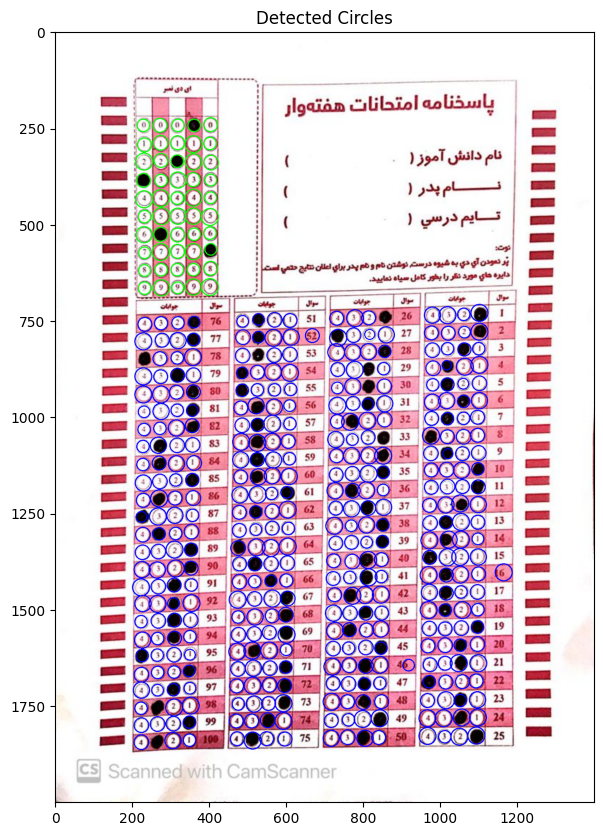

In [75]:
# Display or save the result
showImg(output_img)  # Assuming this function is define

In [76]:
# Function to determine if a circle is filled
def is_circle_filled(roi):
    _, binary_roi = cv2.threshold(roi, 128, 255, cv2.THRESH_BINARY_INV)
    filled_ratio = np.sum(binary_roi) / (binary_roi.shape[0] * binary_roi.shape[1] * 255)
    return filled_ratio > 0.5


In [77]:

# Ensure img_gray is defined, which is the grayscale version of the image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()


In [78]:
# Columns and rows information
columns = 5
rows = 10


In [79]:
# Calculate approximate column positions
min_x = min(x for x, y, r in id_circles)
max_x = max(x for x, y, r in id_circles)
column_width = (max_x - min_x) / (columns - 1)


In [80]:

# Group circles by columns
circles_by_columns = [[] for _ in range(columns)]
for (x, y, r) in id_circles:
    col_idx = int((x - min_x + column_width / 2) / column_width)
    if col_idx >= columns:
        col_idx = columns - 1
    circles_by_columns[col_idx].append((x, y, r))


In [81]:
# Sort circles within each column by y-coordinate (top to bottom)
for col_idx in range(columns):
    circles_by_columns[col_idx].sort(key=lambda circle: circle[1])

In [82]:
# Check each circle to determine if it's filled
filled_numbers = [-1] * columns
for col_idx in range(columns):
    for row_idx, (x, y, r) in enumerate(circles_by_columns[col_idx]):
        roi = img_gray[y-r:y+r, x-r:x+r]
        if is_circle_filled(roi):
            filled_numbers[col_idx] = row_idx
            
# Output the detected filled numbers
print('filled number in the ID section:' , filled_numbers)

filled number in the ID section: [3, 6, 2, 0, 7]


Question 1: Selected Option None
Question 2: Selected Option 1
Question 3: Selected Option 2
Question 4: Selected Option 3
Question 5: Selected Option 3
Question 6: Selected Option 2
Question 7: Selected Option 3
Question 8: Selected Option None
Question 9: Selected Option 3
Question 10: Selected Option 1
Question 11: Selected Option 1
Question 12: Selected Option None
Question 13: Selected Option 3
Question 14: Selected Option None
Question 15: Selected Option 4
Question 16: Selected Option 4
Question 17: Selected Option 3
Question 18: Selected Option 3
Question 19: Selected Option 1
Question 20: Selected Option 2
Question 21: Selected Option None
Question 22: Selected Option 4
Question 23: Selected Option 2
Question 24: Selected Option 2
Question 25: Selected Option 1
Question 26: Selected Option None
Question 27: Selected Option None
Question 28: Selected Option 1
Question 29: Selected Option None
Question 30: Selected Option None
Question 31: Selected Option 2
Question 32: Selected

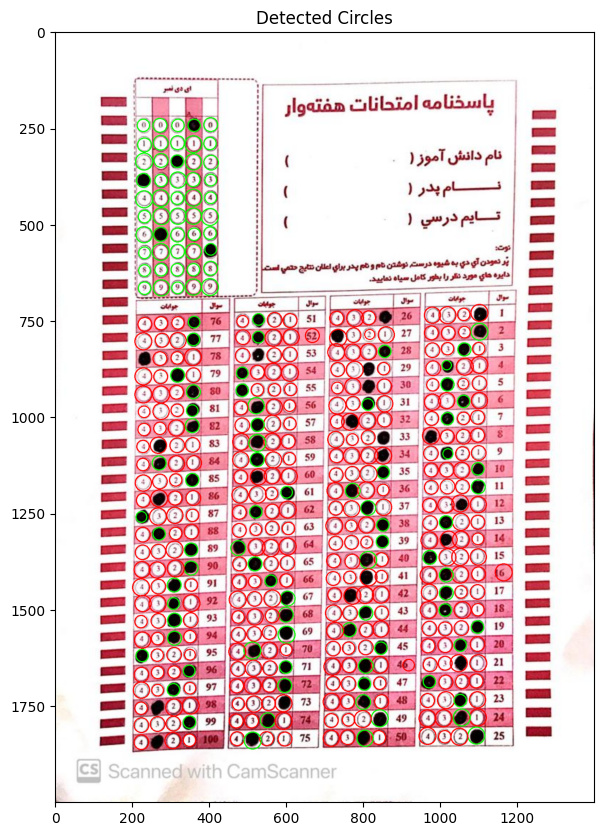

In [83]:
# Function to group circles into columns
def group_circles_by_columns(circles, num_columns):
    sorted_circles = sorted(circles, key=lambda c: c[0], reverse=True)  # Sort by x-coordinate (right to left)
    min_x = min(c[0] for c in sorted_circles)
    max_x = max(c[0] for c in sorted_circles)
    column_width = (max_x - min_x) / num_columns  # Approximate width of each column
    
    columns = [[] for _ in range(num_columns)]
    for circle in sorted_circles:
        col_idx = num_columns - 1 - int((circle[0] - min_x) / column_width)  # Reverse column indexing
        if col_idx < 0:
            col_idx = 0  # Ensure the first column is not skipped
        columns[col_idx].append(circle)
    return columns


# Function to group circles into rows
def group_circles_by_rows(circles, row_height):
    rows = []
    sorted_circles = sorted(circles, key=lambda c: c[1])  # Sort by y-coordinate (vertical position)
    
    current_row = []
    current_y = sorted_circles[0][1]

    for circle in sorted_circles:
        if abs(circle[1] - current_y) > row_height:  # New row detected
            rows.append(current_row)
            current_row = [circle]
            current_y = circle[1]
        else:
            current_row.append(circle)
    
    rows.append(current_row)  # Append the last row
    return rows

# Function to determine the filled option in a question row
def detect_filled_option(row, img_gray):
    filled_option = -1  # Default: no option filled
    for idx, (x, y, r) in enumerate(row):
        roi = img_gray[y-r:y+r, x-r:x+r]
        if is_circle_filled(roi):
            filled_option = idx
            break  # Stop after finding the first filled circle (if only one is expected)
    return filled_option

# Group circles into columns
num_columns = 4
columns = group_circles_by_columns(question_circles, num_columns)

# Detect answers for each question in each column
answers = []
row_height = 35  # Approximate height between rows

for col_idx, column in enumerate(columns):
    # Group circles in the current column by rows
    question_rows = group_circles_by_rows(column, row_height)
    
    # Detect the filled option for each question
    for row_idx, row in enumerate(question_rows):
        row = sorted(row, key=lambda c: c[0] , reverse=True)  # Sort by x-coordinate (left to right)
        filled_option = detect_filled_option(row, img_gray)
        question_number = col_idx * 25 + row_idx + 1  # Calculate question number
        answers.append((question_number, filled_option))

# Display the answers
for question_num, selected_option in answers:
    print(f"Question {question_num}: Selected Option {selected_option + 1 if selected_option != -1 else 'None'}")

# Visualization: Draw detected filled options
for col_idx, column in enumerate(columns):
    for row in group_circles_by_rows(column, row_height):
        for idx, (x, y, r) in enumerate(row):
            color = (0, 255, 0) if is_circle_filled(img_gray[y-r:y+r, x-r:x+r]) else (0, 0, 255)
            cv2.circle(img, (x, y), r, color, 2)

# Display the final result
showImg(img)
